In [1]:
from all_functions import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series

In [19]:
horizon = 12
window = 12
df = pd.read_csv("../datasets/venda/mensal/uf/oleodiesel/mensal_pr_oleodiesel.csv", header=0, parse_dates=['timestamp'], sep=";", date_parser=custom_parser)
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df = df.set_index('timestamp',inplace=False)
df.index = df.index.to_period('M')
series = df['m3']
all_series_test = []
train, test = train_test_stats(series, horizon)
train_val, test_val = train_test_stats(train, horizon)

train_val_normal = transform_train(train_val, format="normal")
train_normal = transform_train(train, format="normal")
all_series_test.append(("normal", train_val_normal, train_normal))

#series sem sazonalidade
train_val_ds = transform_train(train_val, format="deseasonal")
train_tf_ds = transform_train(train, format="deseasonal")

all_series_test.append(("deseasonal", train_val_ds, train_tf_ds))

#series deseasonal + log transform
train_val_ds_log = transform_train(train_val, format="deseasonal-log")
train_tf_ds_log = transform_train(train, format="deseasonal-log")
all_series_test.append(("deseasonal-log", train_val_ds_log, train_tf_ds_log))

#series sem sazonalidade e sem tendencia
train_val_ds_diff = transform_train(train_val, format="deseasonal-diff")
train_tf_ds_diff = transform_train(train, format="deseasonal-diff")
all_series_test.append(("deseasonal-diff", train_val_ds_diff, train_tf_ds_diff))

#series sem tendencia
train_val_diff = transform_train(train_val, format="diff")
train_tf_diff = transform_train(train, format="diff")
all_series_test.append(("diff", train_val_diff, train_tf_diff))

#series log transform
train_val_log = transform_train(train_val, format="log")
train_tf_log = transform_train(train, format="log")
all_series_test.append(("log", train_val_log, train_tf_log))

#series log transform + diff
train_val_log_diff = transform_train(train_val, format="log-diff")
train_tf_log_diff = transform_train(train, format="log-diff")
all_series_test.append(("log-diff", train_val_log_diff, train_tf_log_diff))

path_results_arima = './results/arima/rolling'
derivado = 'gasolinac'
uf = 'PR'
titulo = f"{derivado} em {uf}"
all_preds = []

In [26]:
AR_term = get_AR_terms(train_tf_ds_diff)
MA_term = get_MA_terms(train_tf_ds_diff)
AR_term[0]

2

In [4]:
sarima_order = get_arima_param(path_results_arima, derivado, uf, "diff")
print(sarima_order)
model = ARIMA(order=(AR_term,1,MA_term), 
                seasonal_order=(AR_term,1,MA_term,12),
                # suppress_warnings=True
            )
model.fit(train_tf_ds_diff)
predictions = model.predict(fh=[i for i in range(1, horizon+1)] )
preds_real = reverse_transform_norm_preds(predictions, train, format="diff")

rmse_result = mape(test, preds_real)

(14, 1, 3)


In [22]:
model

ARIMA(order=([2, 4, 6, 8, 9], 1, [3, 4, 9, 10]),
      seasonal_order=([2, 4, 6, 8, 9], 1, [3, 4, 9, 10], 12))

In [20]:
test

timestamp
2023-03    638240.903
2023-04    484554.604
2023-05    550102.550
2023-06    514563.463
2023-07    542258.063
2023-08    617035.758
2023-09    569171.480
2023-10    521946.913
2023-11    509593.008
2023-12    510000.922
2024-01    524759.348
2024-02    524789.842
Freq: M, Name: m3, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

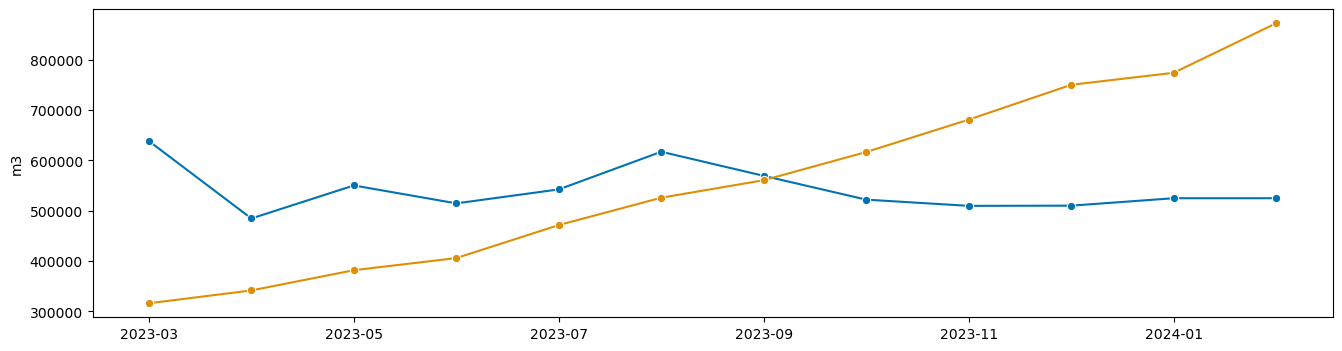

In [21]:
plot_series(test, preds_real)